In [1]:
import numpy as np
import pandas as pd
import vmlab

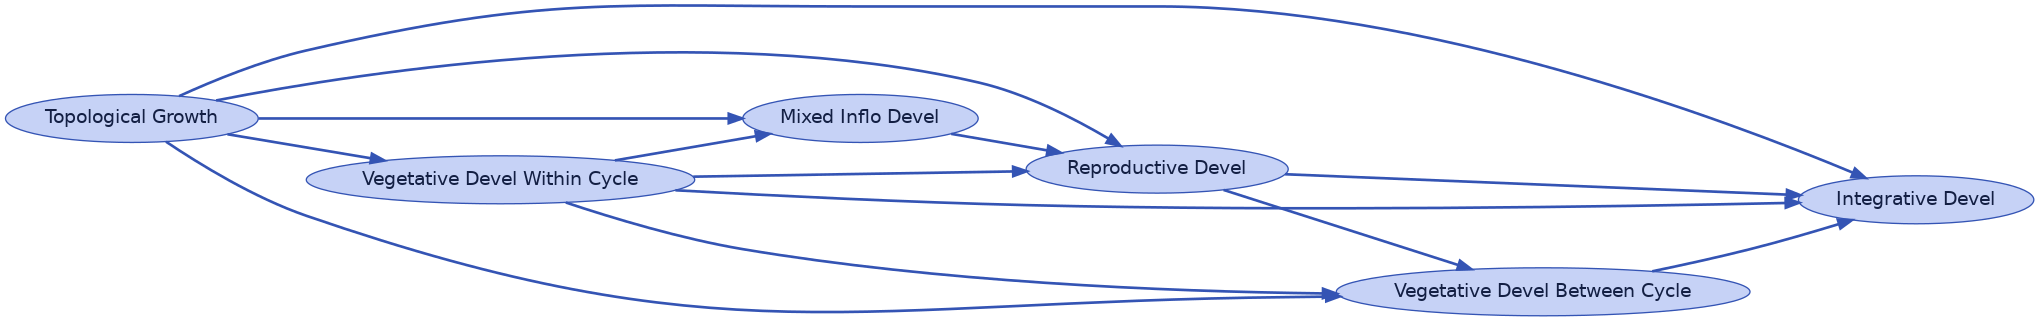

In [2]:
from vmlab.models import arch_dev_model, longname_model
longname_model(arch_dev_model).visualize()

In [3]:
start_date='2003-06-01'
end_date='2005-06-01'
setup = vmlab.create_setup(
    model=arch_dev_model,
    start_date=start_date,
    end_date=end_date,
    setup_toml='arch_dev_model.toml',
    current_cycle=3,
    input_vars={
        'topology__seed': 11
    },
    output_vars={
        'topology': {
            'appearance_date': 'day',
            'cycle': 'day'
        },
        'arch_dev': {
            'pot_burst_date': 'day',
            'pot_nb_inflo': 'day',
            'pot_flowering_date': 'day'
        }
    }
)

In [4]:
ds_out = vmlab.run(setup, arch_dev_model)

             0% | initialize 

In [ ]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS')).plot.bar(figsize=(10,5))

In [ ]:
burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
burst_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS')).plot.bar(figsize=(10,5))

In [ ]:
flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
flowering_date.count().to_dataframe().plot.bar(figsize=(10,5))

In [ ]:
nb_inflo = ds_out.arch_dev__pot_nb_inflo.groupby(ds_out.arch_dev__pot_nb_inflo)
nb_inflo.sum().to_dataframe().plot.bar()

In [ ]:
cycle = ds_out.topology__cycle.groupby(ds_out.topology__cycle)
cycle.count().to_dataframe().plot.bar()